# Early Prediction of Low Cardiac Output and Low Mixed Venous Oxygen Saturation
Can you design and implement a working, open-source algorithm that can, based only on the clinical data provided, automatically identify Low Cardiac Output and Low Mixed Venous Oxygen Saturation.

# 1. Loading libraries

In [215]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')


# 2. Data analysis

In [216]:
# loading datasets for low cardiac output (CO) and low mixed venous oximetry (SvO2)
data_CO = pd.read_csv("hackathon_low_cardiac_output.csv")
data_SvO2 = pd.read_csv("hackathon_low_mixed_venous_oximetry.csv")

## 2.1 Cardiac output

In [217]:
# Take a look at the data fo CO
data_CO.head()

,event_count,ClassificationLabel,RegressionLabel-CardiacIndex,subject_id,SvO2,Heart_Rate,Ejection_Fraction,Radial_Artery_Mean_Pressure,Radial_Artery_Systolic_Pressure,Radial_Artery_Diastolic_Pressure,Radial_Artery_DpDt,Pulmonary_Artery_Mean_Pressure,Central_Venous_Pressure,gender,age_years,bsa,height,weight
0,0,Positive,2.028618,1,52.769959,70.454714,38.748175,77.170900,100.026190,64.022655,423.440484,NaN,NaN,F,47.0,2.32,1.720000,108.0
1,1,Positive,2.399882,1,48.430983,90.727270,26.872010,68.720586,82.300520,59.922332,284.414191,20.887208,8.770792,F,47.0,2.32,1.720000,108.0
2,2,Negative,3.040390,2,71.373351,111.580838,27.932918,78.438025,109.175381,64.293103,591.446707,44.395256,38.562469,M,64.0,1.98,1.803859,85.0
3,3,Negative,2.936209,2,54.384067,96.081832,32.292430,54.741898,79.694792,43.263334,564.566280,20.458315,10.732113,M,64.0,1.98,1.803859,85.0
4,4,Negative,2.520596,2,60.470730,98.000000,28.125170,66.011600,89.259884,55.140781,414.466105,NaN,NaN,M,64.0,1.98,1.803859,85.0


Since variable event_count does not have any information for us, we will drop this column.

In [218]:
data_CO.drop(['event_count'], axis = 1, inplace = True)

In [219]:
print(f'We have now {data_CO.shape[0]} rows and {data_CO.shape[1]} columns in the first dataset related to Cardiac Output (CO).')
print('The columns are:')
for col in data_CO.drop(['RegressionLabel-CardiacIndex', 'subject_id', 'ClassificationLabel'], axis = 1).columns: 
    print('      '+col) 
print(f"From the total {data_CO['subject_id'].count()} observations, there are {data_CO['subject_id'].value_counts().shape[0]} unique ids (patients).")
print(f"There are {sum(data_CO['ClassificationLabel'] == 'Positive')} records with Cardiac index below 2.4 (low cardiac output) and {sum(data_CO['ClassificationLabel'] == 'Negative')} records with Cardiac index equal or greater than 2.4.")

We have now 1972 rows and 17 columns in the first dataset related to Cardiac Output (CO).
The columns are:
      SvO2
      Heart_Rate
      Ejection_Fraction
      Radial_Artery_Mean_Pressure
      Radial_Artery_Systolic_Pressure
      Radial_Artery_Diastolic_Pressure
      Radial_Artery_DpDt
      Pulmonary_Artery_Mean_Pressure
      Central_Venous_Pressure
      gender
      age_years
      bsa
      height
      weight
From the total 1972 observations, there are 399 unique ids (patients).
There are 1012 records with Cardiac index below 2.4 (low cardiac output) and 960 records with Cardiac index equal or greater than 2.4.


Now, we would like to inspect the columns' type and number of non-null observations for each column.

In [220]:
data_CO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 17 columns):
ClassificationLabel                 1972 non-null object
RegressionLabel-CardiacIndex        1972 non-null float64
subject_id                          1972 non-null int64
SvO2                                1935 non-null float64
Heart_Rate                          1972 non-null float64
Ejection_Fraction                   1972 non-null float64
Radial_Artery_Mean_Pressure         1521 non-null float64
Radial_Artery_Systolic_Pressure     1521 non-null float64
Radial_Artery_Diastolic_Pressure    1521 non-null float64
Radial_Artery_DpDt                  1521 non-null float64
Pulmonary_Artery_Mean_Pressure      1376 non-null float64
Central_Venous_Pressure             1389 non-null float64
gender                              1972 non-null object
age_years                           1972 non-null float64
bsa                                 1972 non-null float64
height                     

We can see that we have ClassificationLabel for each observations, however we are dealing with some missing values for SvO2, Radial_Artery_* variables, Pulmonary_Artery_Mean_Pressure and Central_Venous_Pressure. We believe this is due to the fact that those values are obtained via more or less invasive method and so it was not performed for each patient and/or in each measurement. For Pulmonary_Artery_Mean_Pressure and Central_Venous_Pressure there are the most missing values. Those values are measurements taken directly during heart catheterization which is very invasive and in some cases dangerous measurement. We could not just drop those observations out due to small dataset but we can think about dropping these columns. If we drop SvO2 feature, then there will be only features obtained by less invasive and so less dangerous measurements. This would be a big benefit for patient (lower risk) and for doctors as well (time, money) if we can predict CO based only with less invasive methods.

Now, we will investigate the distributions of each column. For this purpose, we will show histograms and boxplots.

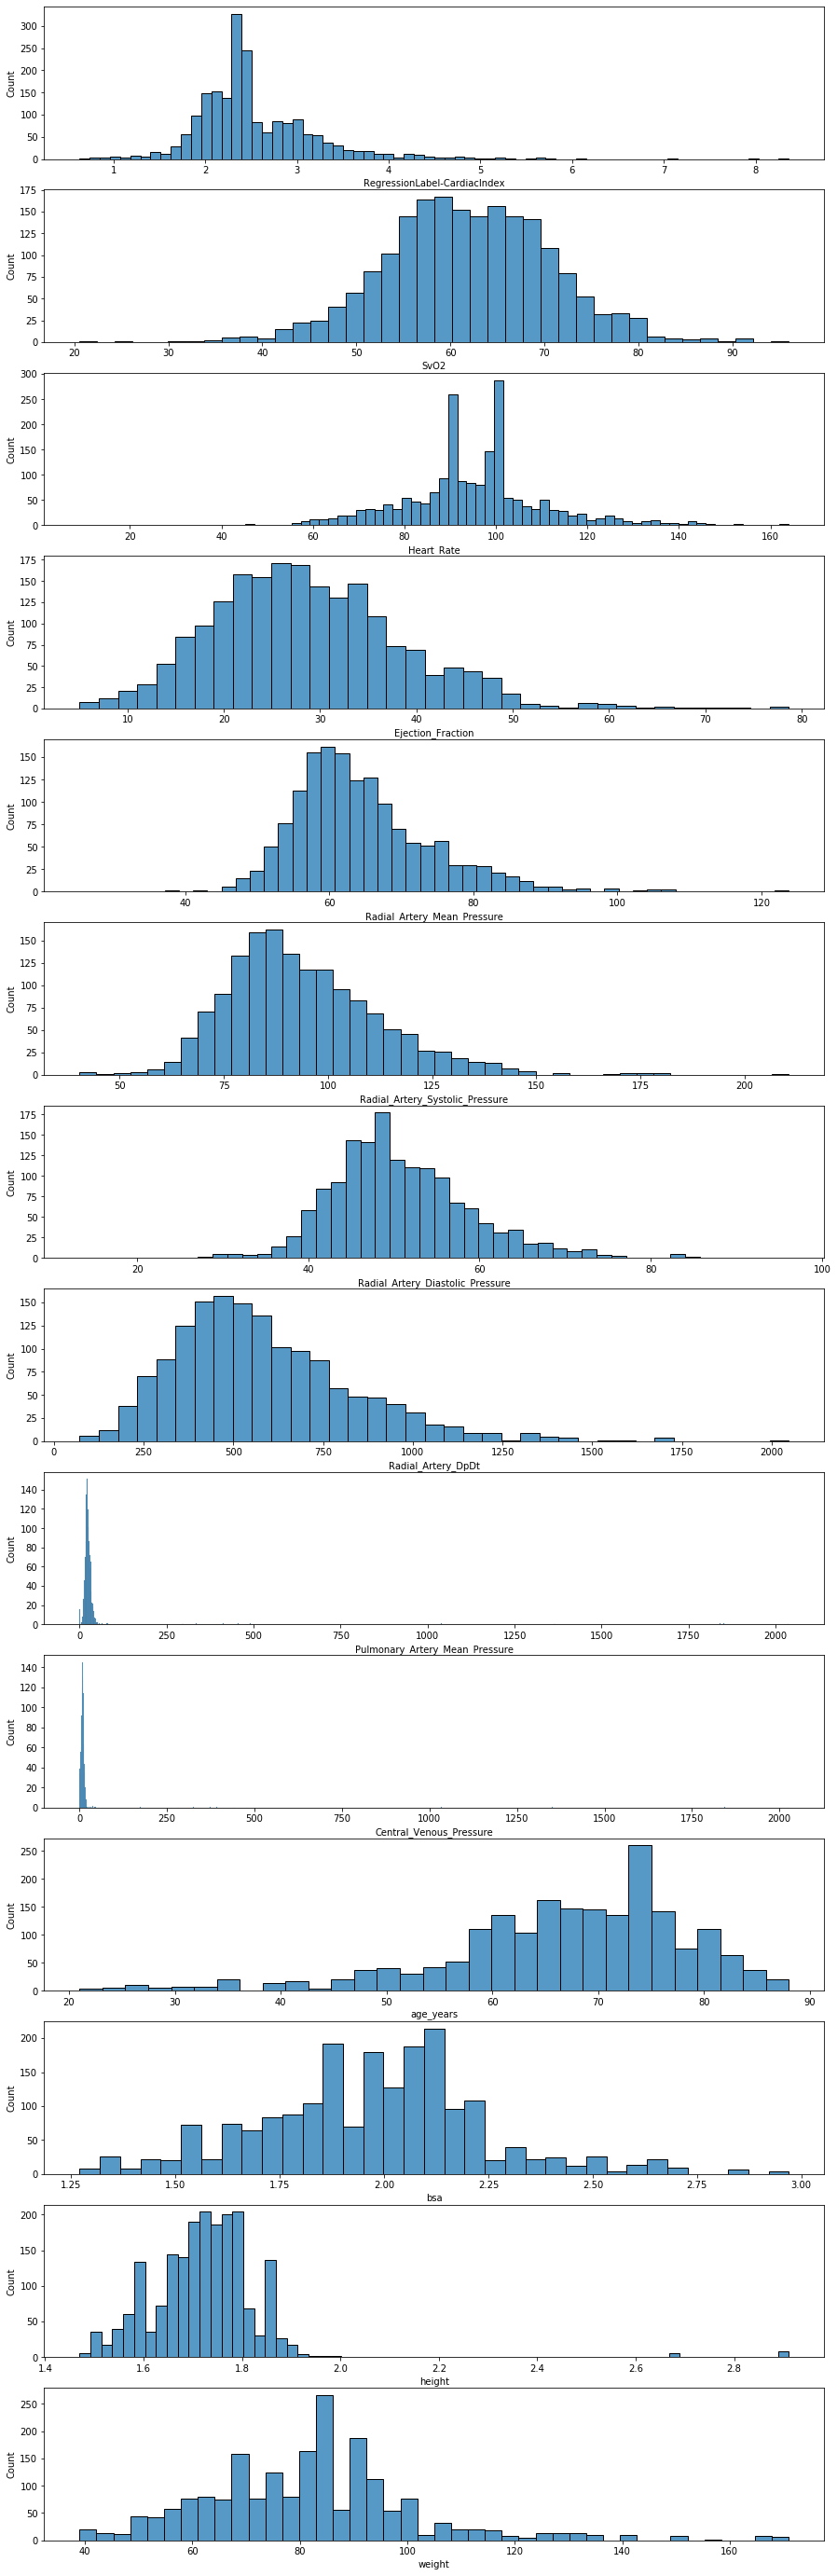

In [221]:
numeric_features = data_CO._get_numeric_data()
numeric_features.drop(['subject_id'], axis = 1, inplace = True)
f, axes = plt.subplots(14, 1, figsize = (15,50))

count = 0
for i in numeric_features.columns:
    sns.histplot(numeric_features[i], ax = axes[count]);
    count = count + 1


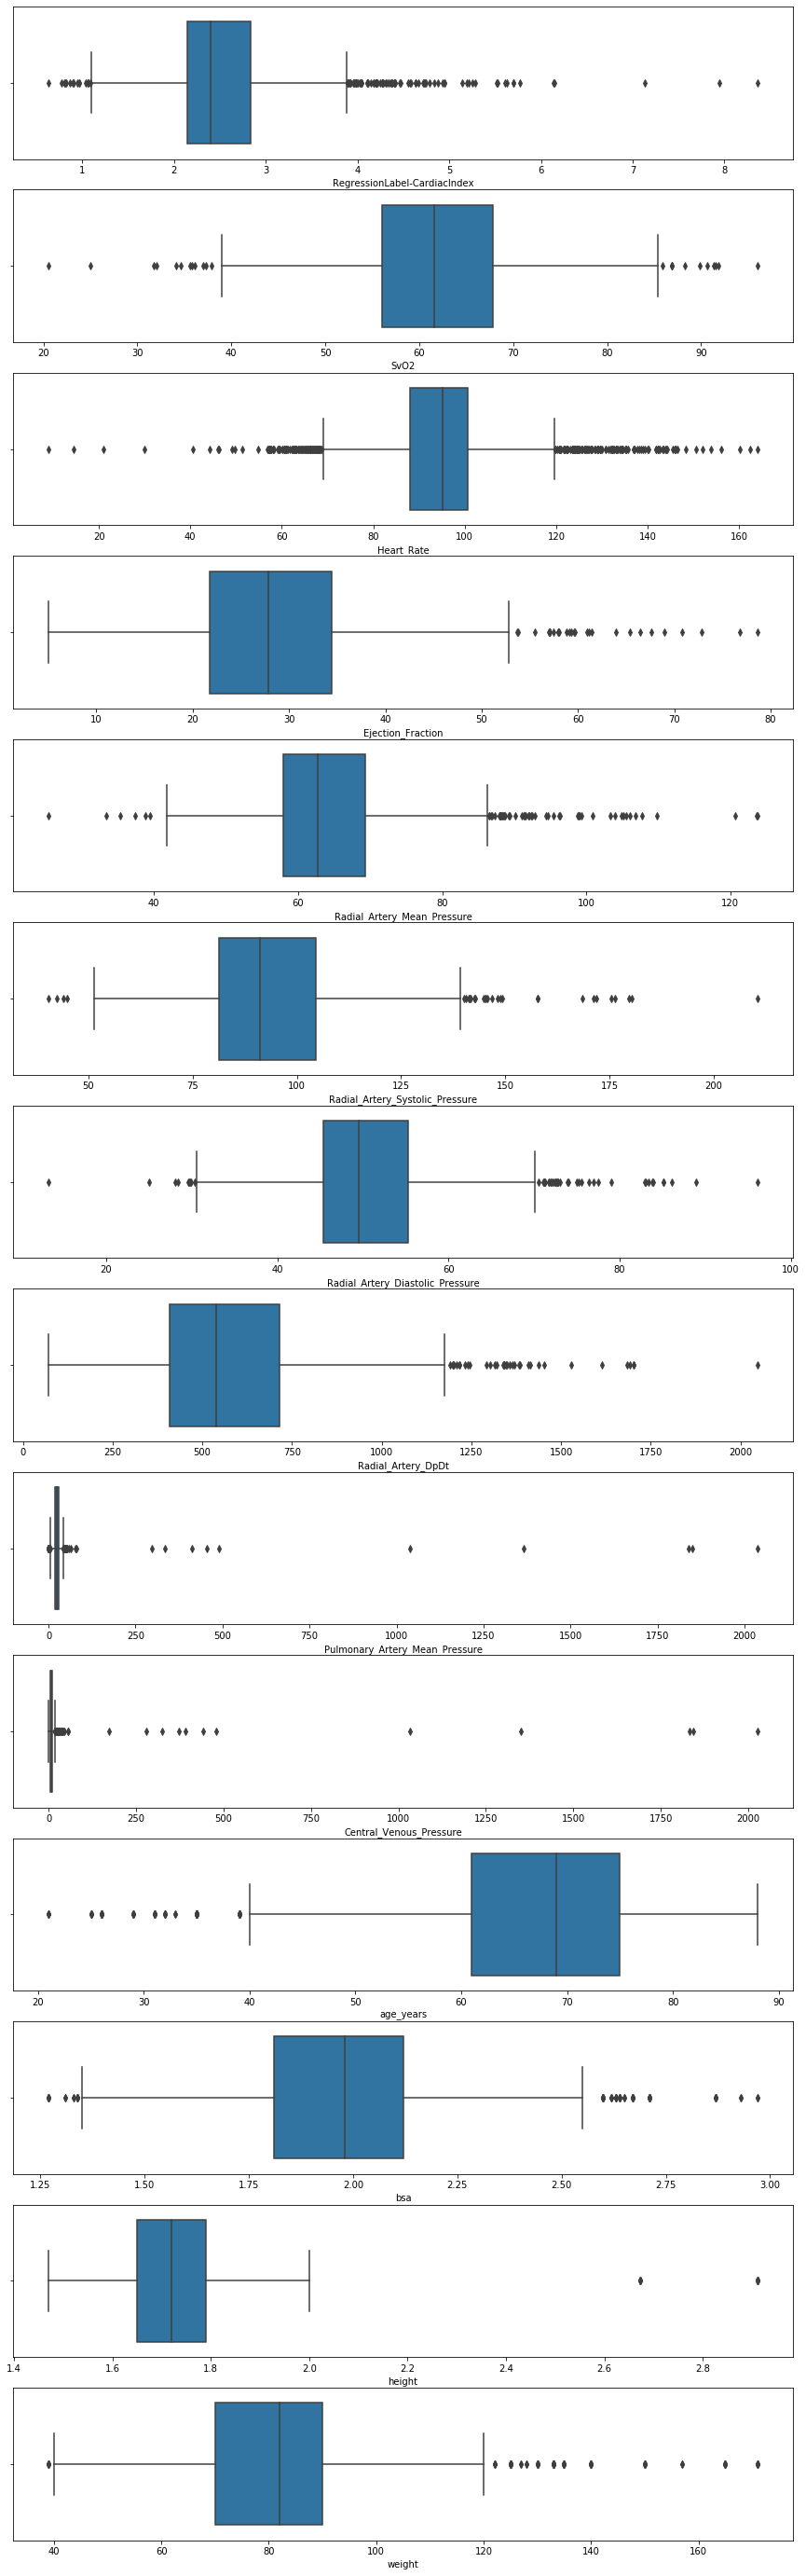

In [222]:
f, axes = plt.subplots(14, 1, figsize = (15,50))

count = 0
for i in numeric_features.columns:
    sns.boxplot(numeric_features[i], ax = axes[count]);
    count = count + 1

## 2.1 Mixed Venous Oxygen Saturation

In [223]:
data_SvO2 = pd.read_csv("hackathon_low_mixed_venous_oximetry.csv")

In [224]:
# Take a look at the SvO2 data
data_SvO2.head()

,event_count,ClassificationLabel,RegressionLabel-SvO2,subject_id,Cardiac_Output,End_Diastolic_Volume,Heart_Rate,Ejection_Fraction,Radial_Artery_Mean_Pressure,Radial_Artery_Systolic_Pressure,Radial_Artery_Diastolic_Pressure,Radial_Artery_DpDt,Pulmonary_Artery_Mean_Pressure,Central_Venous_Pressure,gender,age_years,bsa,height,weight
0,0,Positive,53.200804,1,4.976985,210.274091,75.396362,34.537687,71.631915,92.440422,58.872387,378.710129,NaN,NaN,F,47.0,2.32,1.72,108.0
1,1,Positive,52.632589,1,5.634996,223.621650,77.608280,36.230422,54.944226,66.426038,42.841986,193.781144,NaN,NaN,F,47.0,2.32,1.72,108.0
2,2,Positive,54.994859,1,5.865219,380.740504,36.299038,47.739281,67.673384,81.206194,54.457291,246.854544,18.235936,9.747269,F,47.0,2.32,1.72,108.0
3,3,Positive,55.563019,1,5.482037,124.053266,89.948128,49.949769,66.810973,78.505744,53.820318,258.264984,20.389445,8.968417,F,47.0,2.32,1.72,108.0
4,4,Positive,57.749656,1,5.559628,191.473200,87.636360,35.750260,NaN,NaN,NaN,NaN,18.720792,7.738167,F,47.0,2.32,1.72,108.0


In [225]:
# We will drop the event_count column as it has no information
data_SvO2.drop(['event_count'], axis = 1, inplace = True)

In [226]:
print(f'We have now {data_SvO2.shape[0]} rows and {data_SvO2.shape[1]} columns in the second dataset related to Mixed Venous Oxygen Saturation (SvO2).')
print('The columns are:')
for col in data_SvO2.drop(['RegressionLabel-SvO2', 'subject_id', 'ClassificationLabel'], axis = 1).columns: 
    print('      '+col) 
print(f"From the total {data_SvO2['subject_id'].count()} observations, there are {data_SvO2['subject_id'].value_counts().shape[0]} unique ids (patients).")
print(f"There are {sum(data_SvO2['ClassificationLabel'] == 'Positive')} records with Cardiac index below 60 (low SvO2) and {sum(data_SvO2['ClassificationLabel'] == 'Negative')} records with data_SvO2 equal or greater than 60.")

We have now 2147 rows and 18 columns in the second dataset related to Mixed Venous Oxygen Saturation (SvO2).
The columns are:
      Cardiac_Output
      End_Diastolic_Volume
      Heart_Rate
      Ejection_Fraction
      Radial_Artery_Mean_Pressure
      Radial_Artery_Systolic_Pressure
      Radial_Artery_Diastolic_Pressure
      Radial_Artery_DpDt
      Pulmonary_Artery_Mean_Pressure
      Central_Venous_Pressure
      gender
      age_years
      bsa
      height
      weight
From the total 2147 observations, there are 399 unique ids (patients).
There are 1050 records with Cardiac index below 60 (low SvO2) and 1097 records with data_SvO2 equal or greater than 60.


In [227]:
data_SvO2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2147 entries, 0 to 2146
Data columns (total 18 columns):
ClassificationLabel                 2147 non-null object
RegressionLabel-SvO2                2147 non-null float64
subject_id                          2147 non-null int64
Cardiac_Output                      1650 non-null float64
End_Diastolic_Volume                1650 non-null float64
Heart_Rate                          1650 non-null float64
Ejection_Fraction                   1650 non-null float64
Radial_Artery_Mean_Pressure         1755 non-null float64
Radial_Artery_Systolic_Pressure     1755 non-null float64
Radial_Artery_Diastolic_Pressure    1755 non-null float64
Radial_Artery_DpDt                  1755 non-null float64
Pulmonary_Artery_Mean_Pressure      1596 non-null float64
Central_Venous_Pressure             1603 non-null float64
gender                              2147 non-null object
age_years                           2147 non-null float64
bsa                        

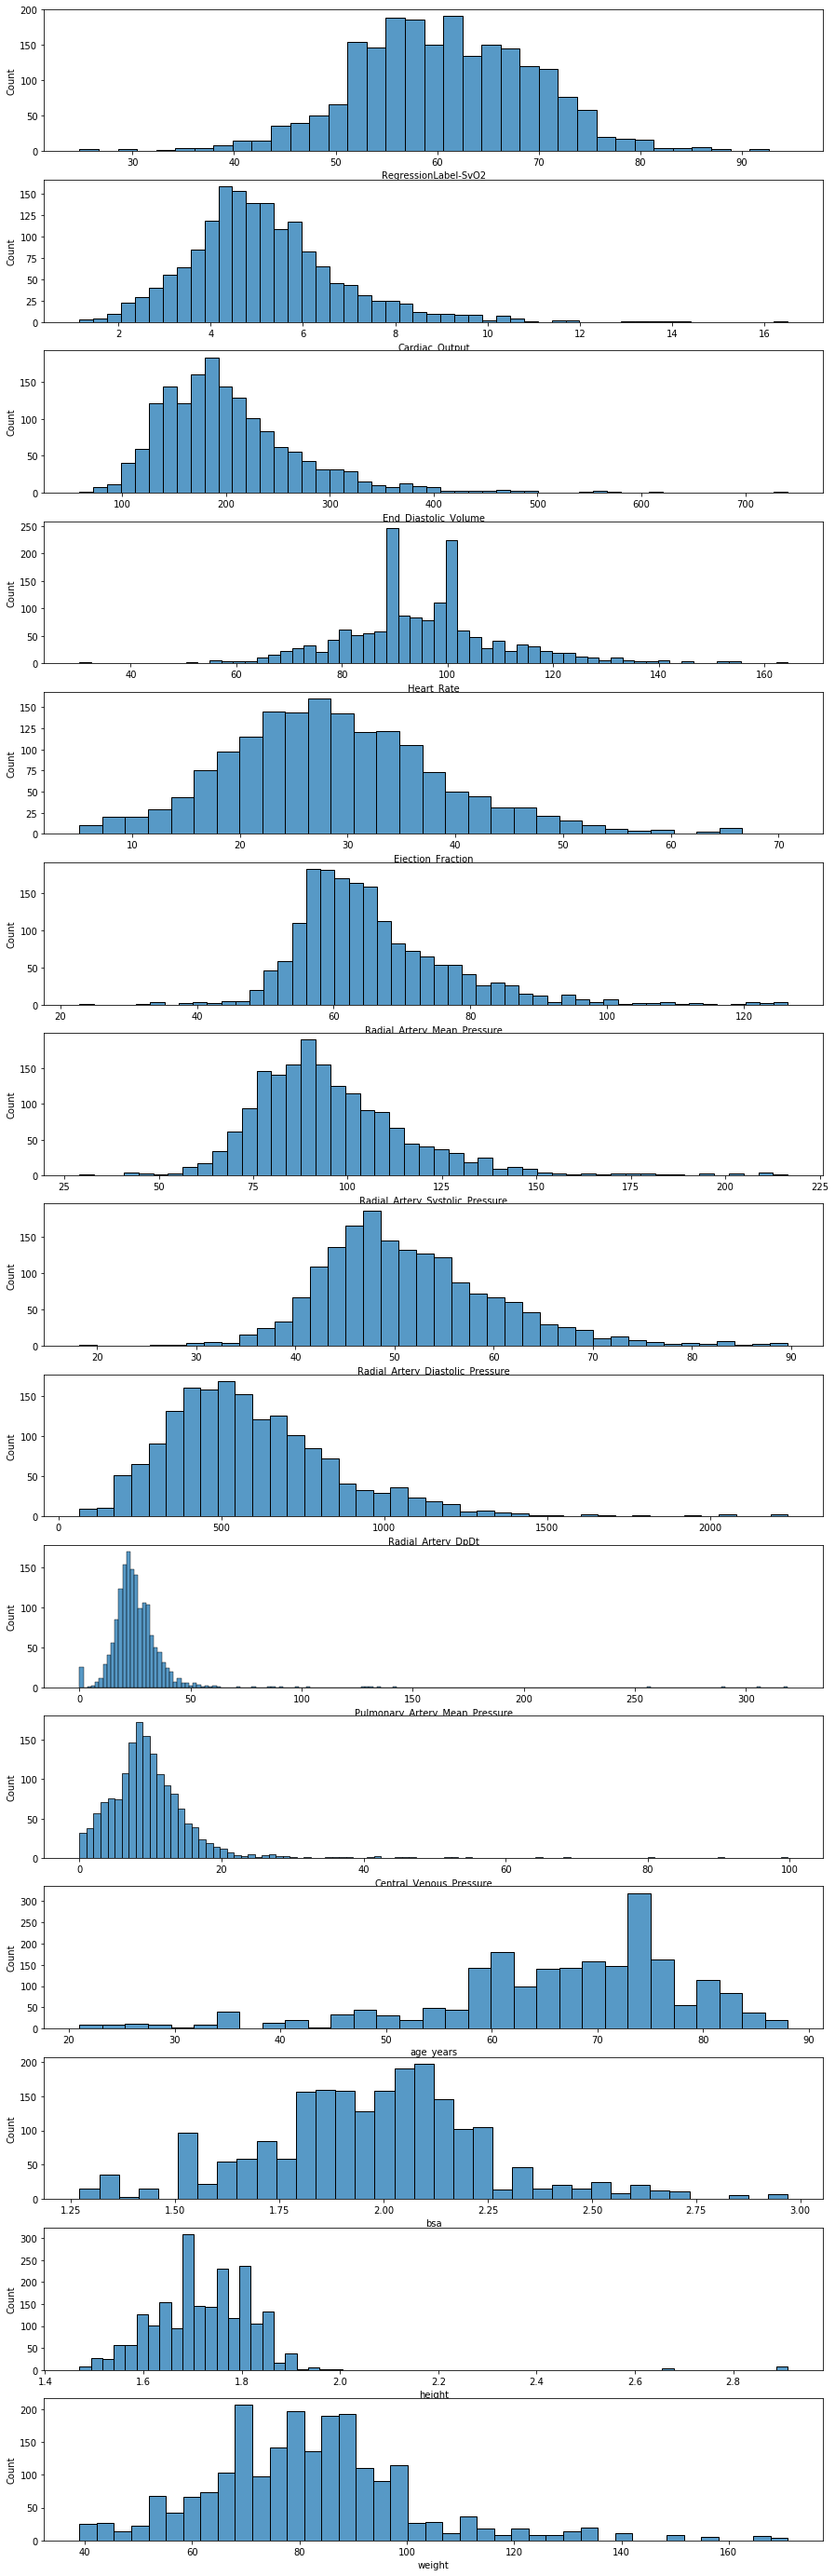

In [228]:
numeric_features = data_SvO2._get_numeric_data()
numeric_features.drop(['subject_id'], axis = 1, inplace = True)
f, axes = plt.subplots(15, 1, figsize = (15,50))

count = 0
for i in numeric_features.columns:
    sns.histplot(numeric_features[i], ax = axes[count])
    count = count + 1



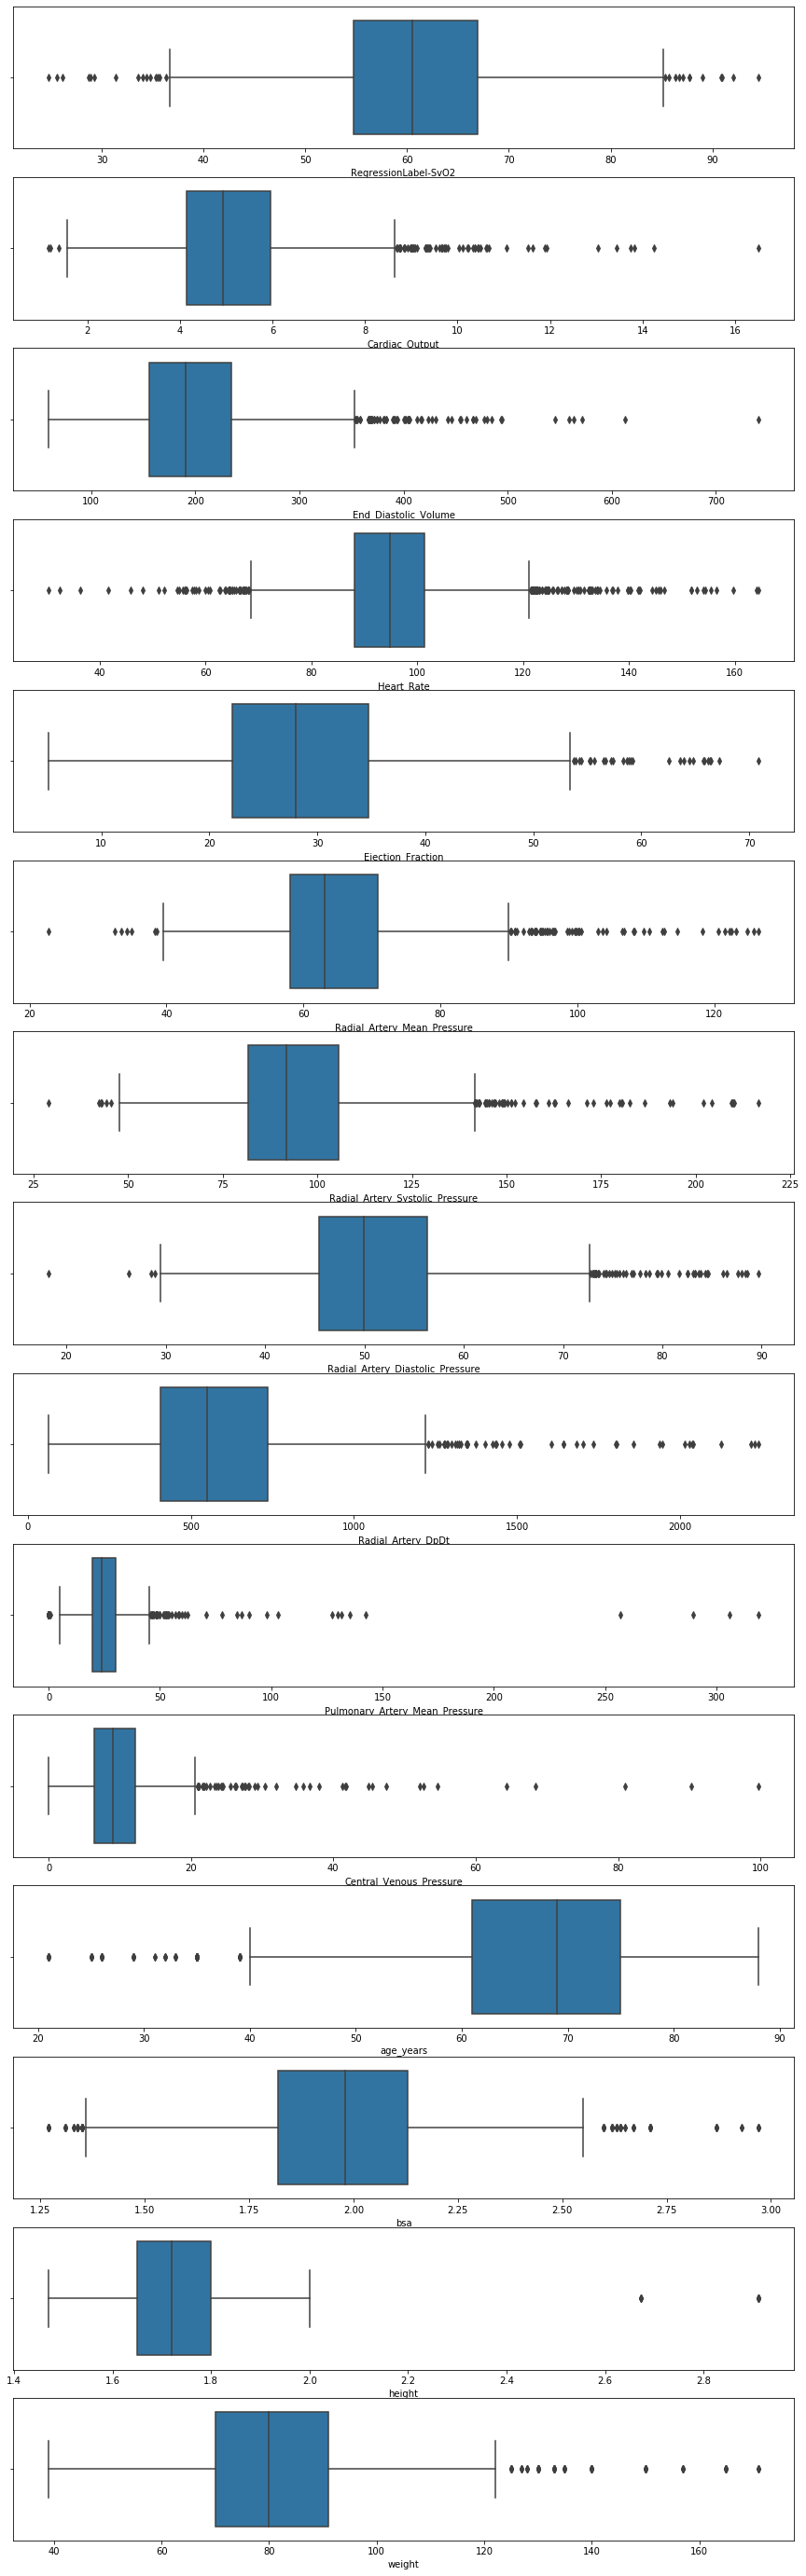

In [229]:
f, axes = plt.subplots(15, 1, figsize = (15,50))

count = 0
for i in numeric_features.columns:
    sns.boxplot(numeric_features[i], ax = axes[count])
    count = count + 1



## 2.3 Joined dataset 

In [230]:
data_CO['warning'] = (data_CO['ClassificationLabel'] == 'Negative').astype(int) + (data_CO['SvO2']>= 60).astype(int)
data_SvO2['warning'] = (data_SvO2['ClassificationLabel'] == 'Negative').astype(int) + (data_SvO2['Cardiac_Output']/data_SvO2['bsa'] >= 2.4).astype(int)
data_SvO2['subject_id'] = data_SvO2['subject_id']*100000
data = pd.concat([data_CO, data_SvO2])

In [242]:
data_SvO2['Cardiac_Output']/data_SvO2['bsa']

0       2.145252
1       2.428877
2       2.528112
3       2.362947
4       2.396391
          ...   
2142    2.287976
2143         NaN
2144         NaN
2145    5.044922
2146    3.644413
Length: 2147, dtype: float64

In [241]:
data_SvO2['Cardiac_Output']/data_SvO2['bsa'] >= 2.4

0       False
1        True
2        True
3       False
4       False
        ...  
2142    False
2143    False
2144    False
2145     True
2146     True
Length: 2147, dtype: bool

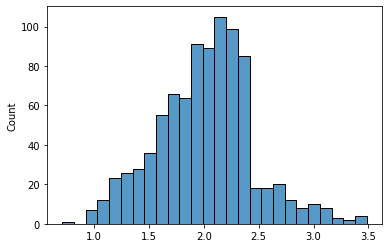

In [243]:
sns.histplot(data[data['warning']==0]['Cardiac_Output'].dropna()/data['bsa'])

In [244]:
data_SvO2['Cardiac_Output']/data_SvO2['bsa']

0       2.145252
1       2.428877
2       2.528112
3       2.362947
4       2.396391
          ...   
2142    2.287976
2143         NaN
2144         NaN
2145    5.044922
2146    3.644413
Length: 2147, dtype: float64

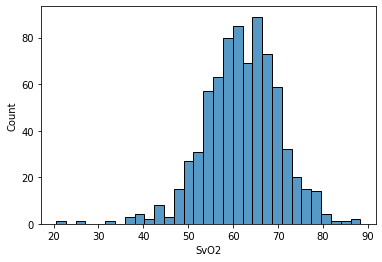

In [245]:
sns.histplot(data[data['warning']==1]['SvO2'].dropna())

### Pulmonary_Artery_Mean_Pressure, Central_Venous_Pressure

Look at the patient with min/max Pulmonary_Artery_Mean_Pressure which is obvisously an outlier

In [246]:
data_CO['SvO2']/(data_CO['bsa'])

0       22.745672
1       20.875424
2       36.047147
3       27.466701
4       30.540773
          ...    
1967    33.276652
1968    32.138460
1969    31.460409
1970    30.920980
1971    32.042024
Length: 1972, dtype: float64

In [247]:
data.iloc[data['Pulmonary_Artery_Mean_Pressure'].idxmax(axis=0, skipna=True)]


Cardiac_Output                           NaN
Central_Venous_Pressure              2026.71
ClassificationLabel                 Positive
Ejection_Fraction                    25.6571
End_Diastolic_Volume                     NaN
Heart_Rate                           85.3835
Pulmonary_Artery_Mean_Pressure        2037.7
Radial_Artery_Diastolic_Pressure     56.0184
Radial_Artery_DpDt                   340.995
Radial_Artery_Mean_Pressure            67.47
Radial_Artery_Systolic_Pressure      87.0722
RegressionLabel-CardiacIndex         1.90293
RegressionLabel-SvO2                     NaN
SvO2                                  56.163
age_years                                 69
bsa                                     2.22
gender                                     M
height                                  1.85
subject_id                                65
warning                                    0
weight                                    95
Name: 282, dtype: object

In [248]:
data.iloc[data['Pulmonary_Artery_Mean_Pressure'].idxmin(axis=0, skipna=True)]

Cardiac_Output                           NaN
Central_Venous_Pressure                    0
ClassificationLabel                 Negative
Ejection_Fraction                    35.9189
End_Diastolic_Volume                     NaN
Heart_Rate                           109.131
Pulmonary_Artery_Mean_Pressure             0
Radial_Artery_Diastolic_Pressure         NaN
Radial_Artery_DpDt                       NaN
Radial_Artery_Mean_Pressure              NaN
Radial_Artery_Systolic_Pressure          NaN
RegressionLabel-CardiacIndex         3.28008
RegressionLabel-SvO2                     NaN
SvO2                                 50.1656
age_years                                 72
bsa                                     1.99
gender                                     M
height                                  1.79
subject_id                               200
warning                                    1
weight                                    79
Name: 972, dtype: object

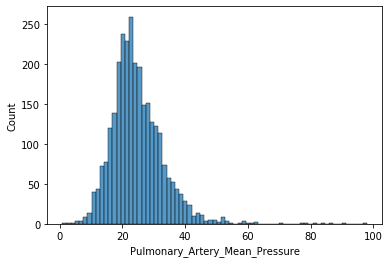

In [249]:
ok_data = data[(data['Pulmonary_Artery_Mean_Pressure'] < 100) & (data['Pulmonary_Artery_Mean_Pressure'] > 0)]
sns.histplot(ok_data['Pulmonary_Artery_Mean_Pressure']);


The same for patient with min/max Central_Venous_Pressure

In [250]:
ok_data.iloc[data['Central_Venous_Pressure'].idxmax(axis=0, skipna=True)]

Cardiac_Output                           NaN
Central_Venous_Pressure              4.34344
ClassificationLabel                 Negative
Ejection_Fraction                    43.4647
End_Diastolic_Volume                     NaN
Heart_Rate                           89.7762
Pulmonary_Artery_Mean_Pressure       10.0269
Radial_Artery_Diastolic_Pressure     52.1118
Radial_Artery_DpDt                   776.297
Radial_Artery_Mean_Pressure          69.5369
Radial_Artery_Systolic_Pressure      110.607
RegressionLabel-CardiacIndex          3.7405
RegressionLabel-SvO2                     NaN
SvO2                                 67.5018
age_years                                 61
bsa                                     2.05
gender                                     M
height                                  1.75
subject_id                                87
warning                                    2
weight                                    85
Name: 402, dtype: object

In [251]:
data.iloc[data['Central_Venous_Pressure'].idxmin(axis=0, skipna=True)]

Cardiac_Output                           NaN
Central_Venous_Pressure                    0
ClassificationLabel                 Positive
Ejection_Fraction                    23.8899
End_Diastolic_Volume                     NaN
Heart_Rate                           109.471
Pulmonary_Artery_Mean_Pressure       24.6796
Radial_Artery_Diastolic_Pressure     50.5645
Radial_Artery_DpDt                   699.852
Radial_Artery_Mean_Pressure          62.9215
Radial_Artery_Systolic_Pressure      98.3965
RegressionLabel-CardiacIndex         2.39835
RegressionLabel-SvO2                     NaN
SvO2                                 58.4358
age_years                                 73
bsa                                     2.19
gender                                     M
height                                  1.82
subject_id                               142
warning                                    0
weight                                    93
Name: 693, dtype: object

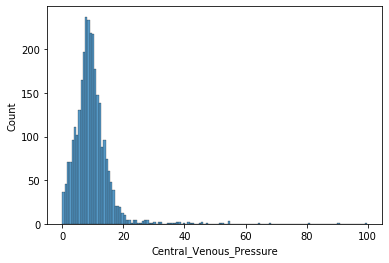

In [252]:
ok_data = data[(data['Central_Venous_Pressure'] < 100) & (data['Central_Venous_Pressure'] > 0)]
sns.histplot(ok_data['Central_Venous_Pressure']);

In [253]:
print(f'There are in total {((data["Pulmonary_Artery_Mean_Pressure"] == 0) & (data["Central_Venous_Pressure"] == 0)).sum()} observations with both zero values in Pulmonary_Artery_Mean_Pressure and Central_Venous_Pressure.')
print(f'For Pulmonary_Artery_Mean_Pressure, there are {(data["Pulmonary_Artery_Mean_Pressure"] == 0).sum()} zero values.')
print(f'For Central_Venous_Pressure, there are {(data["Central_Venous_Pressure"] == 0).sum()} zero values.')
print(f'There are in total {((data["Pulmonary_Artery_Mean_Pressure"] > 100) & (data["Central_Venous_Pressure"] > 100)).sum()} observations with both values greater than 100 in Pulmonary_Artery_Mean_Pressure and Central_Venous_Pressure.')
print(f'For Pulmonary_Artery_Mean_Pressure, there are {(data["Pulmonary_Artery_Mean_Pressure"] > 100).sum()} observations with greater values than 100.')
print(f'For Central_Venous_Pressure, there are {(data["Central_Venous_Pressure"] > 100).sum()} observations with greater values than 100.')


There are in total 16 observations with both zero values in Pulmonary_Artery_Mean_Pressure and Central_Venous_Pressure.
For Pulmonary_Artery_Mean_Pressure, there are 40 zero values.
For Central_Venous_Pressure, there are 28 zero values.
There are in total 10 observations with both values greater than 100 in Pulmonary_Artery_Mean_Pressure and Central_Venous_Pressure.
For Pulmonary_Artery_Mean_Pressure, there are 20 observations with greater values than 100.
For Central_Venous_Pressure, there are 12 observations with greater values than 100.


We can see that there are outliers mainly in Pulmonary_Artery_Mean_Pressure and Central_Venous_Pressure feature (those value make no sense) so we would like to drop those observations. In case of pressure variables, we believe that this is due to wrong unit (decimal separator) or non-measurements in case of zero values but there are only few such observations so we can drop them as it will not affect our model much. In case there are more such outliers, we will choose to correct them and include in our model but this is not our case. In order to make prediction, we can simply correct the decimal place and insert it corrected to our model (so this is how we will deal with such outliers in validation and/or test datasets). In most cases, an outlier in Pulmonary_Artery_Mean_Pressure means an outlier in Central_Venous_Pressure.

In [254]:
# Drop observations with zero or extremely high (higher than 100) Central_Venous_Pressure and/or Pulmonary_Artery_Mean_Pressure
data = data[(data['Central_Venous_Pressure']<100) & (data['Pulmonary_Artery_Mean_Pressure']<100) & (data['Central_Venous_Pressure']>0) & (data['Pulmonary_Artery_Mean_Pressure']>0) ]

### Heart rate

In [255]:
print(f'The minimum measured heart rate is {np.nanmin(data["Heart_Rate"])} beats per minute. This indicates us some measurement errors which we wanna exclude from our dataset.')
print(f'We have in total {sum(data["Heart_Rate"] <= 30)} observations with heart rate less than or equal to 30 beats per minute. As this perhaps is due to some measurement error, we will exclude those observations from our dataset.')
print(f'The maximum measured heart rate is {np.round(np.nanmax(data["Heart_Rate"]))} beats per minute. This could rarely occur for sick patient or for patient who is not still so we will not exclude those high values.')

The minimum measured heart rate is 9.0 beats per minute. This indicates us some measurement errors which we wanna exclude from our dataset.
We have in total 2 observations with heart rate less than or equal to 30 beats per minute. As this perhaps is due to some measurement error, we will exclude those observations from our dataset.
The maximum measured heart rate is 164.0 beats per minute. This could rarely occur for sick patient or for patient who is not still so we will not exclude those high values.


In [256]:
# Drop observations with heart rate less than or equal to 30
data = data[data['Heart_Rate']>30]

### Height

In [257]:
print(f'The minimum measured height is {np.nanmin(data["height"])} m.')
print(f'The maximum measured height is {np.round(np.nanmax(data["height"]),2)} m. We would like to drop')


The minimum measured height is 1.47 m.
The maximum measured height is 2.91 m. We would like to drop


In [258]:
# Let us look at people with height more than 2 m
data[data['height']>2.4]

,Cardiac_Output,Central_Venous_Pressure,ClassificationLabel,Ejection_Fraction,End_Diastolic_Volume,Heart_Rate,Pulmonary_Artery_Mean_Pressure,Radial_Artery_Diastolic_Pressure,Radial_Artery_DpDt,Radial_Artery_Mean_Pressure,...,RegressionLabel-CardiacIndex,RegressionLabel-SvO2,SvO2,age_years,bsa,gender,height,subject_id,warning,weight
830,NaN,5.389391,Negative,37.145401,NaN,110.913681,19.233021,46.447396,664.745271,58.109998,...,3.553064,NaN,69.644411,67.0,1.55,F,2.911307,173,2,165.0
831,NaN,3.459798,Negative,30.965476,NaN,127.706836,19.175019,49.243345,724.512827,59.837524,...,2.991350,NaN,67.030100,67.0,1.55,F,2.911307,173,2,165.0
834,NaN,3.567937,Negative,38.576320,NaN,99.083340,18.711583,48.698503,880.077061,59.847472,...,2.693617,NaN,70.373470,67.0,1.55,F,2.911307,173,2,165.0
835,NaN,4.305069,Negative,25.492190,NaN,146.545500,18.949528,49.743711,579.891633,58.915054,...,2.439548,NaN,50.784789,67.0,1.55,F,2.911307,173,1,165.0
967,5.965920,4.722700,Negative,37.667116,148.867977,106.653791,17.177234,46.199205,668.480431,59.223879,...,NaN,73.383744,NaN,67.0,1.55,F,2.911307,17500000,2,165.0
969,4.803959,5.092933,Negative,34.814806,125.613654,110.160993,18.514053,48.310887,686.863255,58.948401,...,NaN,72.670222,NaN,67.0,1.55,F,2.911307,17500000,2,165.0
972,5.412407,5.581014,Negative,39.122090,129.722800,105.300000,18.509611,46.132858,750.135562,57.914269,...,NaN,64.824237,NaN,67.0,1.55,F,2.911307,17500000,2,165.0
973,4.713937,3.615792,Negative,31.462680,122.204900,109.727300,18.755812,51.962313,955.206166,64.301995,...,NaN,66.674910,NaN,67.0,1.55,F,2.911307,17500000,2,165.0


We can see that we have only two patients (probably it is only one but we assume that CO and SvO2 datasets are independent) with height more than 2.4 meters (it is 2.9m) so we definitely want to drop these observations as there is some error.

In [259]:
# Drop observations with height more than 2.4 m
data = data[data['height']<=2.4]

### Weight

In [260]:
print(f'The minimum measured weight is {np.nanmin(data["weight"])} kg.')
print(f'The maximum measured weight is {np.round(np.nanmax(data["weight"]),2)} kg.')

The minimum measured weight is 39.0 kg.
The maximum measured weight is 157.0 kg.


We have weight from 39 kilograms to 157 kilograms. Those values are alright so no correction there.

### Radial_Artery_Mean_Pressure, Radial_Artery_Systolic_Pressure, Radial_Artery_Diastolic_Pressure and Radial_Artery_DpDt

After looking at graphs above and consultation with our mentor, we decided to drop observations with values outside the following intervals:
    -           40 < Radial_Artery_Mean_Pressure      < 140
    -           60 < Radial_Artery_Systolic_Pressure  < 160
    -           30 < Radial_Artery_Diastolic_Pressure < 100

In [261]:
# Drop observations with values outside our defined ranges
data = data[(data['Radial_Artery_Mean_Pressure']<140) & (data['Radial_Artery_Mean_Pressure']>40) & (data['Radial_Artery_Systolic_Pressure']>60) & (data['Radial_Artery_Systolic_Pressure']<160)& (data['Radial_Artery_Diastolic_Pressure']>30) & (data['Radial_Artery_Diastolic_Pressure']<100) ]

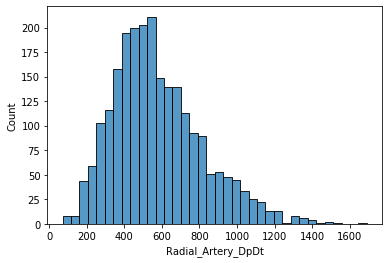

In [262]:
sns.histplot(data['Radial_Artery_DpDt']);

In [263]:
print(f'The minimum measured weight is {np.nanmin(data["Radial_Artery_DpDt"])} mmHg/Time.')
print(f'The maximum measured weight is {np.round(np.nanmax(data["Radial_Artery_DpDt"]),2)} mmHg/Time.')


The minimum measured weight is 71.52070499905463 mmHg/Time.
The maximum measured weight is 1691.36 mmHg/Time.


As we do not see these values non-realistic, we will not drop any observations based on Radial_Artery_DpDt.

## Take a look at histograms after dropping outliers


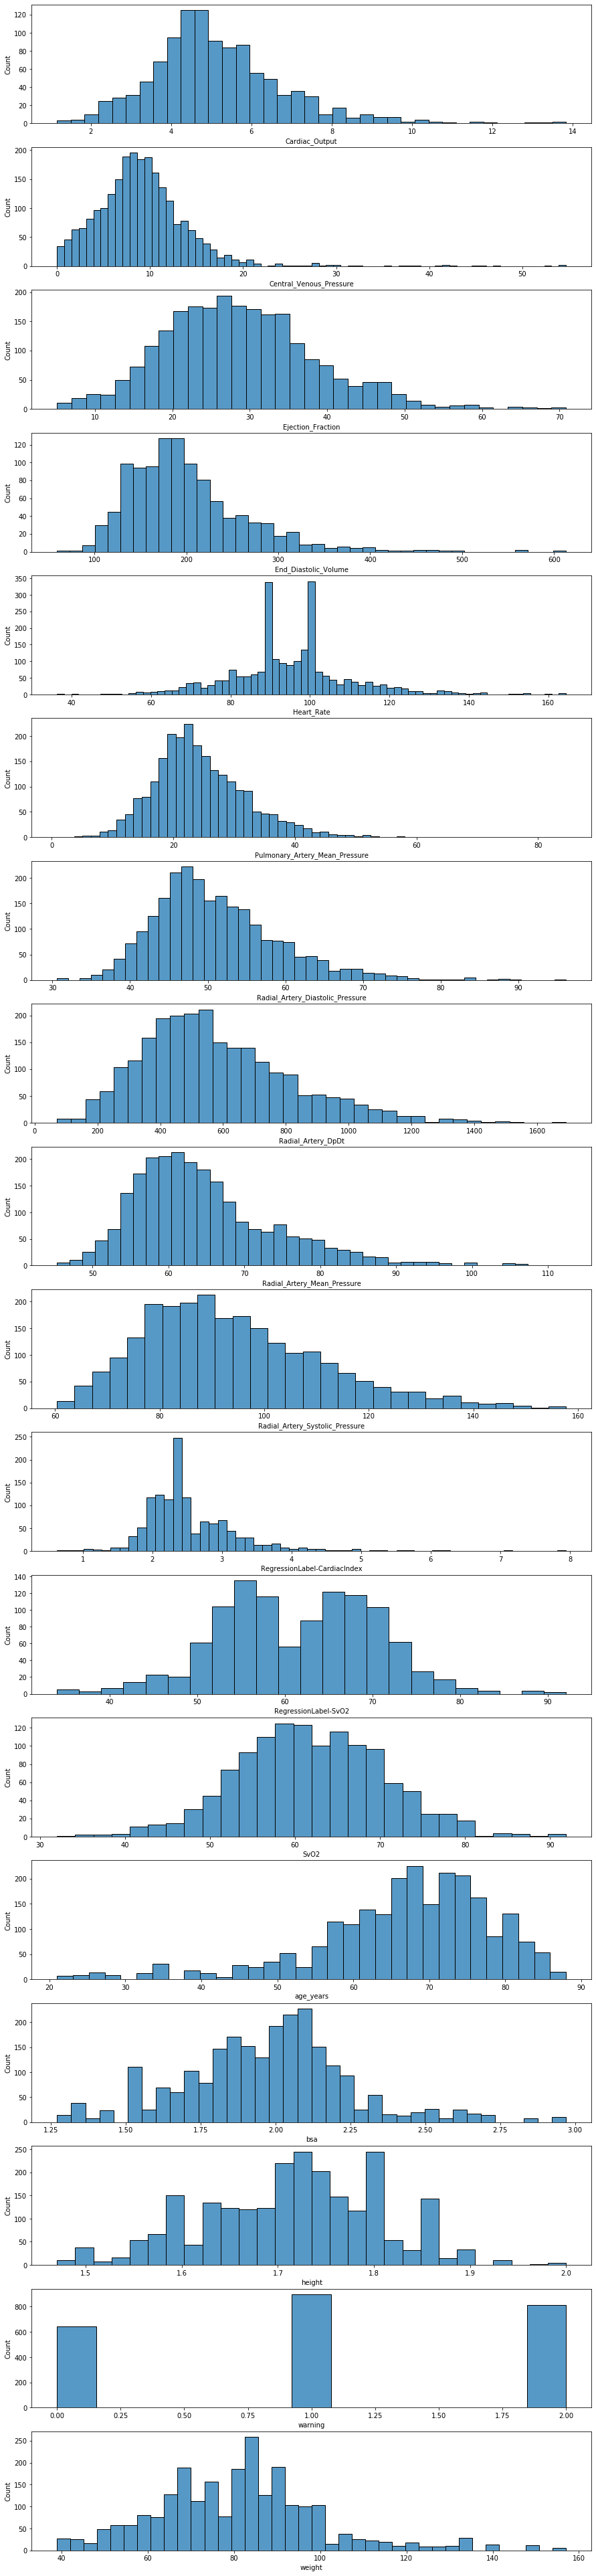

In [264]:
numeric_features = data._get_numeric_data()
numeric_features.drop(['subject_id'], axis = 1, inplace = True)
f, axes = plt.subplots(18, 1, figsize = (15,70))
count = 0
for i in numeric_features.columns:
    sns.histplot(numeric_features[i], ax = axes[count])
    count = count + 1


Now the dataset looks more reasonable.

## Make categorical 

In [265]:
data = pd.get_dummies(data,drop_first=True)
data.drop(['SvO2', 'RegressionLabel-SvO2','RegressionLabel-CardiacIndex', 'Cardiac_Output', 'End_Diastolic_Volume'], axis = 1, inplace = True)
#

## Correlation Analysis

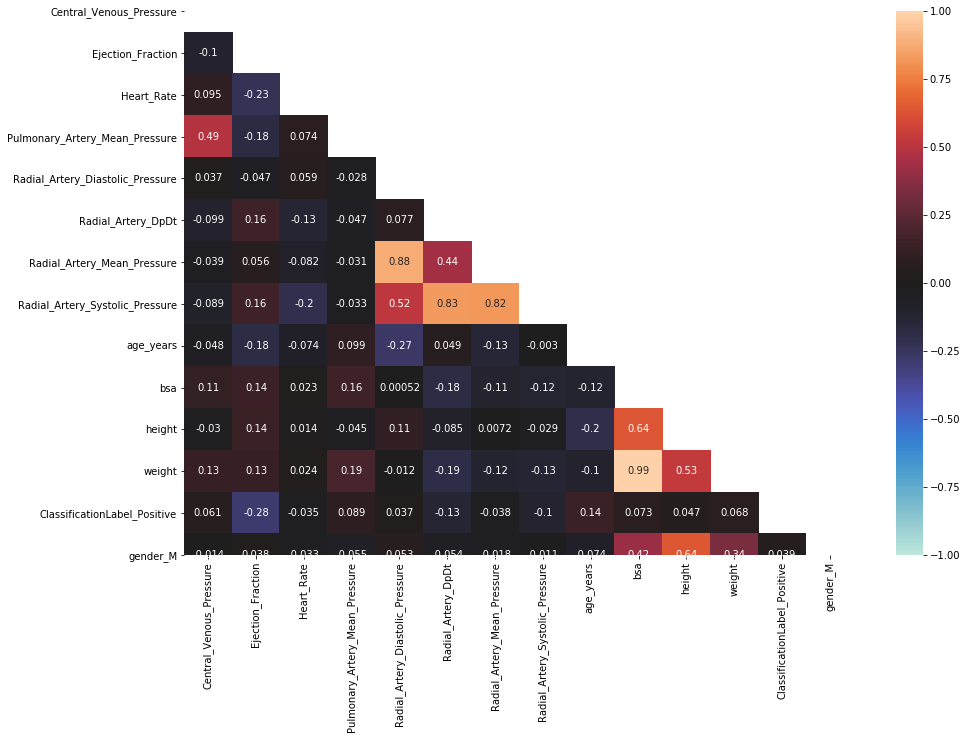

In [266]:
matrix = np.triu(data.drop(['subject_id','warning'], axis=1).corr())
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(data.drop(['subject_id', 'warning'], axis=1).corr(), annot = True, vmin=-1, vmax=1, center= 0, mask=matrix, ax=ax);

### Central_Venous_Pressure,  Pulmonary_Artery_Mean_Pressure relationship

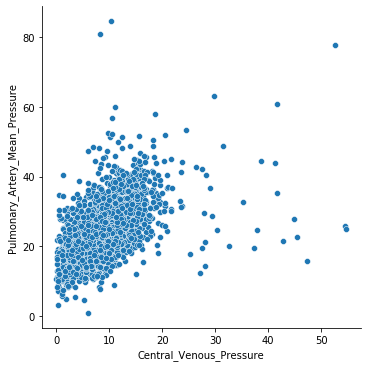

In [267]:
sns.relplot(x="Central_Venous_Pressure", y="Pulmonary_Artery_Mean_Pressure", data=data);

### Body surface area, weight and height relationship

There is simplified formula how to calculate body surface area from weight and height, let us take a look at the differences between actual bsa and computed bsa

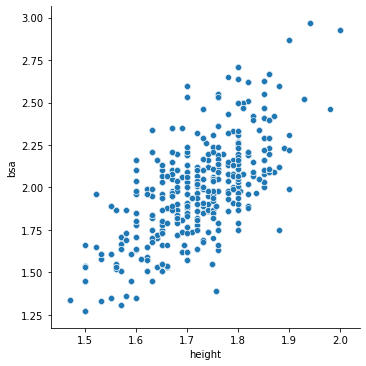

In [268]:
sns.relplot(x="height", y="bsa", data=data);

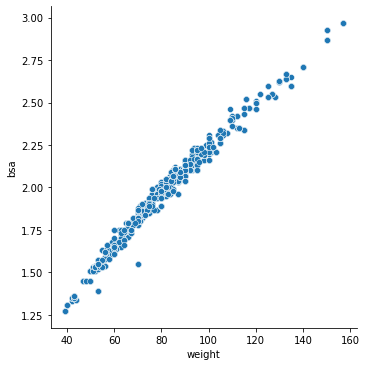

In [269]:
sns.relplot(x="weight", y="bsa", data=data);

In [270]:
data["bsa_computed"] = 0.0016667*(data['weight']**0.5)*(100*data["height"]**0.5)

In [271]:
(data["bsa"] - data["bsa_computed"])/data["bsa"]

1       0.020858
2      -0.042325
3      -0.042325
5      -0.042325
6      -0.001061
          ...   
2131    0.004249
2136    0.008134
2137    0.008134
2139    0.008134
2146    0.003487
Length: 2355, dtype: float64

We should definitely keep only bsa or weight and height in our linear regression model.

# 3. Data processing

Based on analysis above, we would like to process our train/validation and test datasets in order to start building the model. In order to make it easier, we will define function which takes names of input files and random seed as input. This function returns three datasets, train, validation and test. It also deals with outliers and missing values. Outliers are removed based on ranges from analysis above and consultation with our mentor. For missing data problem, we will use multivariate imputer that estimates each feature from all the others.

In [3]:

def data_preprocessing(data_CO_file: str, dataSvO2_file: str, data_CO_file_test: str, data_SvO2_file_test: str, rand: int):
    # train, valid data
    data_CO, data_SvO2 = pd.read_csv(data_CO_file), pd.read_csv(dataSvO2_file)

    data_CO['warning'] = (data_CO['ClassificationLabel'] == 'Negative').astype(int) + (data_CO['SvO2'] >= 60).astype(int)
    data_SvO2['warning'] = (data_SvO2['ClassificationLabel'] == 'Negative').astype(int) + (data_SvO2['Cardiac_Output'] >= 2.4).astype(int)
    
    data_CO["target"] = (data_CO['ClassificationLabel'] == 'Positive').astype(int)# + 2*(data_CO['SvO2'] < 60).astype(int) > 0
    data_SvO2["target"] = (data_SvO2['Cardiac_Output']/data_SvO2['bsa'] < 2.4).astype(int) #+ 2*(data_SvO2['ClassificationLabel'] == 'Positive').astype(int) > 0

    data_SvO2['subject_id'] = data_SvO2['subject_id']*100000

    data = pd.concat([data_CO, data_SvO2])
    data.drop(['Pulmonary_Artery_Mean_Pressure', 'Central_Venous_Pressure','event_count', 'ClassificationLabel','RegressionLabel-CardiacIndex', 'SvO2', 'RegressionLabel-SvO2', 'Cardiac_Output', 'End_Diastolic_Volume'], axis = 1, inplace = True)
    
    #data = data[(data['Central_Venous_Pressure']<100) & (data['Pulmonary_Artery_Mean_Pressure']<100) & (data['Central_Venous_Pressure']>0) & (data['Pulmonary_Artery_Mean_Pressure']>0)]
    data = data[data['Heart_Rate']>30]
    data = data[data['height']<=2.4]
    data = data[(data['Radial_Artery_Mean_Pressure']<140) & (data['Radial_Artery_Mean_Pressure']>40) & (data['Radial_Artery_Systolic_Pressure']>60) & (data['Radial_Artery_Systolic_Pressure']<160)& (data['Radial_Artery_Diastolic_Pressure']>30) & (data['Radial_Artery_Diastolic_Pressure']<100) ]
   
    data = pd.get_dummies(data,drop_first = True)
    
    data_train = pd.DataFrame(columns = data.columns)
    data_val = pd.DataFrame(columns = data.columns)
    np.random.seed(rand)
    
    for index in np.unique(data['subject_id']):
        yes_or_no = np.random.binomial(1, 0.8)
        if yes_or_no == 1:
            data_train = data_train.append(data[data["subject_id"] == index])
        else:
            data_val = data_val.append(data[data["subject_id"] == index])

    X = data_train.drop(['warning', 'subject_id', 'target'], axis = 1)
    Y = data_train['target']
    #Y = data_train['warning']
    reg_imputer = IterativeImputer()
    reg_imputer
    reg_imputer.fit(X)    
    X_imputed = pd.DataFrame(reg_imputer.transform(X), columns = X.columns, index = X.index)
    
    X_val = data_val.drop(['warning', 'subject_id', 'target'], axis = 1)
    Y_val = data_val['target']
    X_val_imputed = pd.DataFrame(reg_imputer.transform(X_val), columns = X_val.columns, index = X_val.index)

    # test data
    data_CO_test, data_SvO2_test = pd.read_csv(data_CO_file_test), pd.read_csv(data_SvO2_file_test)


    data_CO_test["target"] = (data_CO_test['ClassificationLabel'] == 'Positive').astype(int) #+ 2*(data_CO_test['SvO2'] < 60).astype(int) > 0
    data_SvO2_test["target"] = (data_SvO2_test['Cardiac_Output']/data_SvO2_test['bsa'] < 2.4).astype(int) #+ 2*(data_SvO2_test['ClassificationLabel'] == 'Positive').astype(int) > 0


    data_CO_test['warning'] = (data_CO_test['ClassificationLabel'] == 'Negative').astype(int) + (data_CO_test['SvO2'] >= 60).astype(int)
    data_SvO2_test['warning'] = (data_SvO2_test['ClassificationLabel'] == 'Negative').astype(int) + (data_SvO2_test['Cardiac_Output'] >= 2.4).astype(int)
    data_test = pd.concat([data_CO_test, data_SvO2_test])
    data_test.drop(['Pulmonary_Artery_Mean_Pressure', 'Central_Venous_Pressure','event_count', 'ClassificationLabel','RegressionLabel-CardiacIndex', 'SvO2','RegressionLabel-SvO2', 'Cardiac_Output', 'End_Diastolic_Volume'], axis = 1, inplace = True)

    data_test = pd.get_dummies(data_test,drop_first = True)

    X_test = data_test.drop(['warning', 'subject_id', 'target'], axis = 1)
    Y_test = data_test['target']
    X_test_imputed = pd.DataFrame(reg_imputer.transform(X_test), columns = X_test.columns, index = X_test.index)
    
    return({'train_data': pd.concat([X_imputed, Y], axis = 1), 'valid_data': pd.concat([X_val_imputed, Y_val], axis = 1), 'test_data': pd.concat([X_test_imputed, Y_test], axis = 1)})
    
        

In [296]:
data = data_preprocessing("hackathon_low_cardiac_output.csv", "hackathon_low_mixed_venous_oximetry.csv", "hackathon_low_cardiac_output_test_set.csv", "hackathon_low_mixed_venous_oximetry_test_set.csv", 10)

# 4. Building models

In [297]:
X_columns = ['Heart_Rate', 'Ejection_Fraction', 'Radial_Artery_Mean_Pressure',
       'Radial_Artery_Systolic_Pressure', 'Radial_Artery_Diastolic_Pressure',
       'Radial_Artery_DpDt', 'age_years', 'bsa', 'height', 'weight',
       'gender_M']
y_column = 'warning'

In [298]:
X_train = data['train_data'][X_columns]
X_valid = data['valid_data'][X_columns]
X_test = data['test_data'][X_columns]

y_train = data['train_data'][y_column].astype('int')
y_valid = data['valid_data'][y_column].astype('int')
y_test = data['test_data'][y_column].astype('int')

In [301]:
import statsmodels.api as sm
model = sm.OLS(y_train,X_train)
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                warning   R-squared (uncentered):                   0.720
Model:                            OLS   Adj. R-squared (uncentered):              0.718
Method:                 Least Squares   F-statistic:                              513.8
Date:                Sun, 22 Nov 2020   Prob (F-statistic):                        0.00
Time:                        10:42:51   Log-Likelihood:                         -2365.2
No. Observations:                2214   AIC:                                      4752.
Df Residuals:                    2203   BIC:                                      4815.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

In [289]:
# Feature Scaling - Must be done!
import sklearn.preprocessing
import sklearn.pipeline

standard_scaler = sklearn.preprocessing.StandardScaler()
polynomial_features = sklearn.preprocessing.PolynomialFeatures(2, include_bias=True)

pipeline = sklearn.pipeline.Pipeline([
    ("standard_scaler", standard_scaler),
    ("polynomial_features", polynomial_features)
])


X_train = pipeline.fit_transform(X_train)
# X_valid = pipeline.transform(X_valid)
X_test = pipeline.transform(X_test)

In [ ]:
# For 3 classes
def prediction(predicted_probability, threshold = 0.5):
    y_pred = np.zeros(len(y_pred_prob))
    for index, value in enumerate(predicted_probability):    
        if predicted_probability[index][3] > threshold:  # cim viac znizujem, tym viac hovorim nech model dava 1 = Positive
            y_pred[index] = 3
        elif predicted_probability[index][2] > threshold:
            y_pred[index] = 2
        elif predicted_probability[index][1] > threshold:
            y_pred[index] = 1
        else:
            y_pred[index] = 0
    return y_pred

In [290]:
# For 2 classes
def prediction(predicted_probability, threshold = 0.5):
    y_pred = np.zeros(len(y_pred_prob))
    for index, value in enumerate(predicted_probability):    
        if predicted_probability[index][1] > threshold:  # cim viac znizujem, tym viac hovorim nech model dava 1 = Positive
            y_pred[index] = 1
        else:
            y_pred[index] = 0
    return y_pred

In [2]:
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C=100, solver='lbfgs', random_state = 0)
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', random_state = 0, probability=True) #'rbf'
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
from sklearn.svm import SVC
svm2 = SVC(kernel = 'rbf', random_state = 0, probability=True)
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
log = LogisticRegressionCV(solver='lbfgs', random_state = 0, cv=5)
log.fit(X_train, y_train)

#y_pred = log.predict(X_test)

y_pred_prob = log.predict_proba(X_test)
y_pred = prediction(y_pred_prob, 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm/sum(sum(cm)))

# print(f"Accuracy: {sum(cm[i][i] for i in range(4))/sum(sum(cm))}")

from sklearn.metrics import precision_recall_fscore_support
#precision_recall_fscore_support(y_test, y_pred, average='macro')

In [300]:
y_pred_prob = log.predict_proba(X_test)
y_pred = prediction(y_pred_prob, 0.34)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm/sum(sum(cm)))
print(cm)
print(sum(sum(cm)))

array([[0.04636364, 0.17090909, 0.06545455],
       [0.04545455, 0.21636364, 0.17      ],
       [0.01727273, 0.1       , 0.16818182]])

In [295]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
ensemble = StackingClassifier(estimators=[
        ('xbg', xgb),
        ('random_forest', random_forest),
        ('decision_tree', decision_tree),
        ('log', log),
        ('svm', svm),
        ('svm2', svm2),
        ('bayes', bayes)], cv=5)
ensemble = ensemble.fit(X_train, y_train)

# y_pred_prob = ensemble.predict_proba(X_test)
# y_pred = prediction(y_pred_prob, 0.4)

y_pred = ensemble.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm/sum(sum(cm))

NameError: name 'xgb' is not defined

In [ ]:
# Fitting SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0, probability=True) #'rbf'
classifier.fit(X_train, y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_test)
# y_pred_prob = classifier.predict_proba(X_test)
# y_pred = prediction(y_pred_prob, 0.4)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
# y_pred_prob = classifier.predict_proba(X_test)
# y_pred = prediction(y_pred_prob, 0.4)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
# Fitting Kernel SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0, probability=True)
classifier.fit(X_train, y_train)

# Predicting the Test set results
#y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)
y_pred = prediction(y_pred_prob, 0.4)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
#y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)
y_pred = prediction(y_pred_prob, 0.4)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
#y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)
y_pred = prediction(y_pred_prob, 0.4)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
#y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)
y_pred = prediction(y_pred_prob, 0.4)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

# Predicting the Test set results
#y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)
y_pred = prediction(y_pred_prob, 0.4)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

# 5. Results

In [4]:
# Best fit logistic regression

In [6]:
'''
[[0.20454545 0.47545455]
 [0.05       0.27      ]]
'''

'\n[[0.20454545 0.47545455]\n [0.05       0.27      ]]\n'